In [1]:
!nvidia-smi

Tue May 26 00:20:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 665kB 4.7MB/s 
     |████████████████████████████████| 3.8MB 18.8MB/s 
     |████████████████████████████████| 1.1MB 54.5MB/s 
     |████████████████████████████████| 890kB 46.7MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/196-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [6]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64/fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64/fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64/fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64/fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64/fold_5.tar.gz'

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_64/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,train,train,validation,train,False
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train,False
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,validation,train,train,train,False
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,validation,train,train,train,False
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,validation,train,train,False


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 64,
  "BATCH_SIZE": 32,
  "EPOCHS": 7,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 3,
  "N_FOLDS": 5,
  "question_size": 4,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 1e-07 to 2.95e-05 to 1e-06


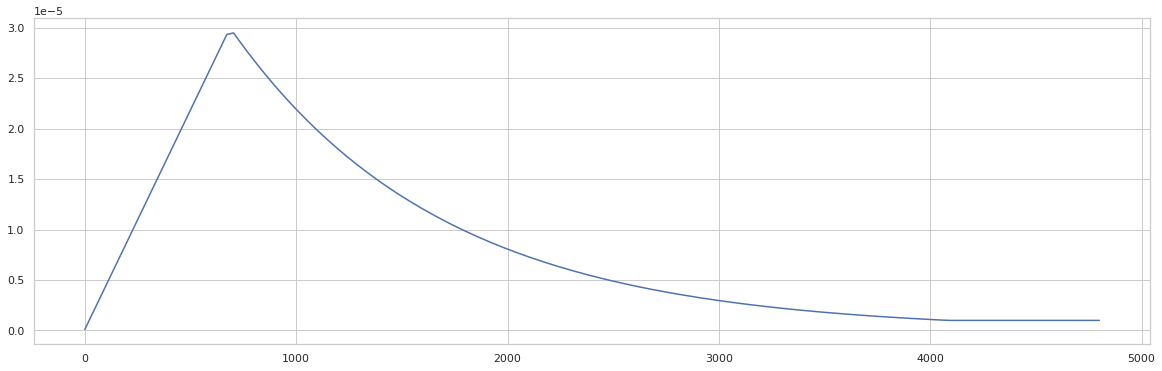

In [11]:
lr_min = 1e-6
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
warmup_steps = step_size * 1
decay = .999

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=warmup_steps, lr_start=lr_start, 
                                      lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=True)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    _, _, hidden_states = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    h08 = hidden_states[-5]
    
    x = layers.Dropout(.1)(h08)
    
    x_start = layers.Dense(1)(x)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)
    
    x_end = layers.Dense(1)(x)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)

    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [13]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))

    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=warmup_steps, lr_start=lr_start, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(label_smoothing=0.2),
                                   'y_end': losses.CategoricalCrossentropy(label_smoothing=0.2)})
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=False, verbose=1)
    checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED),
                        validation_data=(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED)),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        validation_steps=valid_step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    
    # Make predictions (last model)
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])
    
    # Make predictions (best model)
    model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold_best, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])


FOLD: 1
Epoch 1/7
687/687 - 124s - loss: 4.8985 - y_start_loss: 2.3756 - y_end_loss: 2.5228 - val_loss: 3.9529 - val_y_start_loss: 1.9882 - val_y_end_loss: 1.9647
Epoch 2/7
687/687 - 124s - loss: 3.9033 - y_start_loss: 1.9575 - y_end_loss: 1.9457 - val_loss: 3.8198 - val_y_start_loss: 1.9326 - val_y_end_loss: 1.8872
Epoch 3/7
687/687 - 124s - loss: 3.7504 - y_start_loss: 1.8907 - y_end_loss: 1.8597 - val_loss: 3.8113 - val_y_start_loss: 1.9217 - val_y_end_loss: 1.8896
Epoch 4/7
687/687 - 124s - loss: 3.6717 - y_start_loss: 1.8567 - y_end_loss: 1.8149 - val_loss: 3.7988 - val_y_start_loss: 1.9157 - val_y_end_loss: 1.8831
Epoch 5/7
687/687 - 124s - loss: 3.6205 - y_start_loss: 1.8298 - y_end_loss: 1.7907 - val_loss: 3.7853 - val_y_start_loss: 1.9146 - val_y_end_loss: 1.8707
Epoch 6/7
687/687 - 120s - loss: 3.5926 - y_start_loss: 1.8180 - y_end_loss: 1.7746 - val_loss: 3.8016 - val_y_start_loss: 1.9133 - val_y_end_loss: 1.8883
Epoch 7/7
687/687 - 120s - loss: 3.5808 - y_start_loss: 1.810

# Model loss graph

Fold: 1


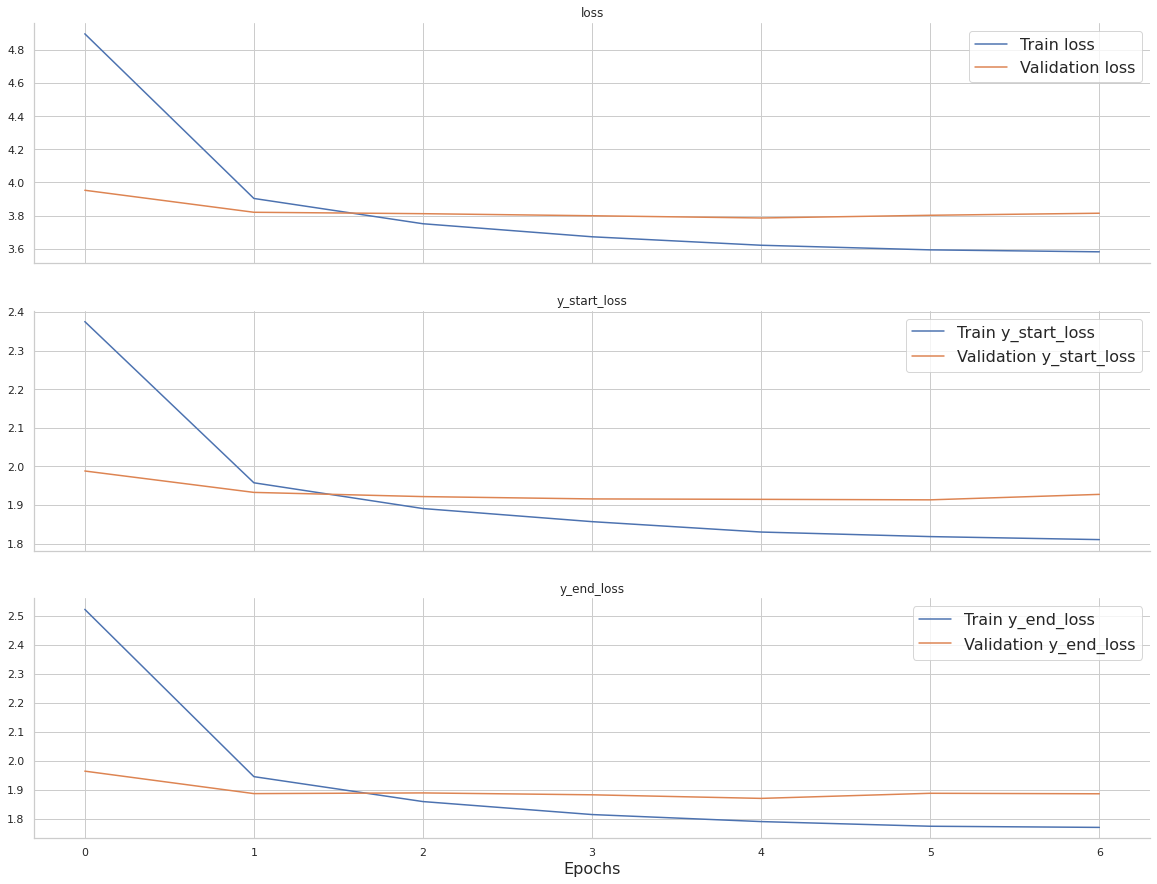

Fold: 2


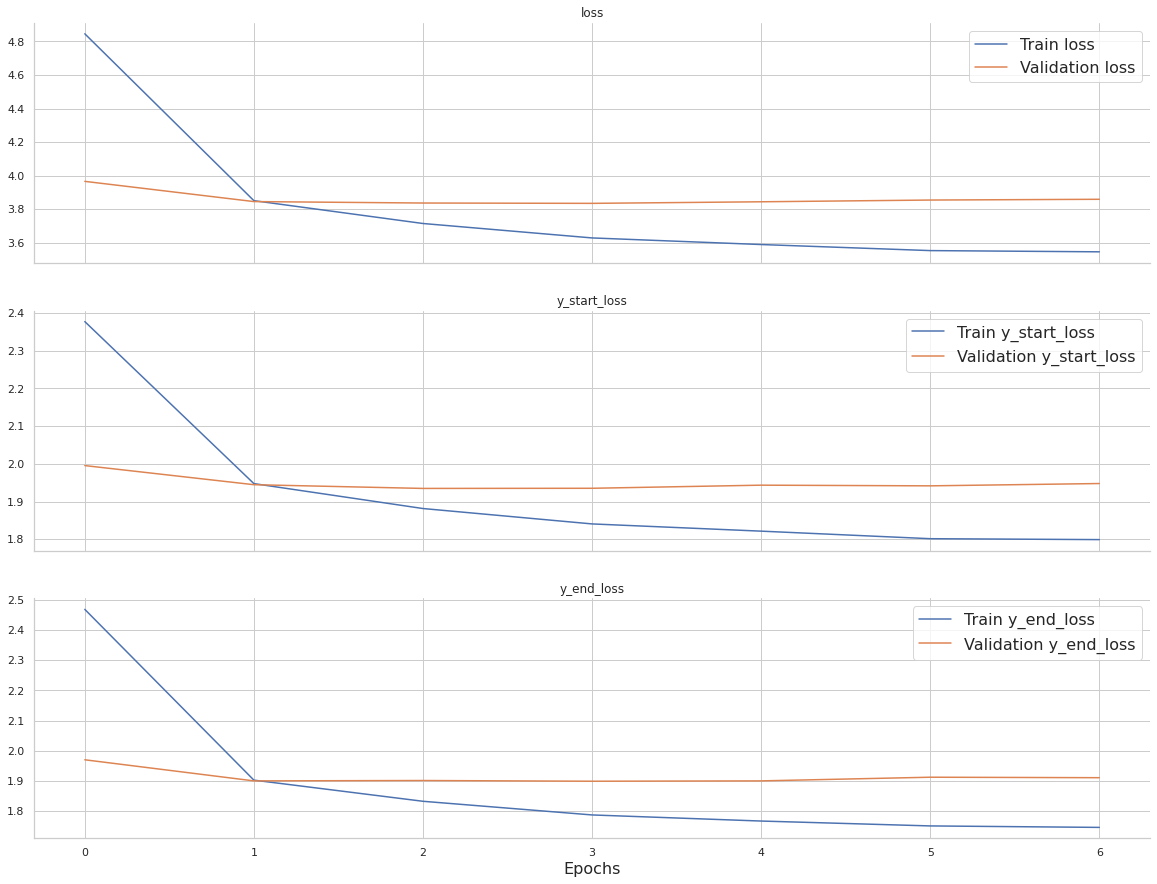

Fold: 3


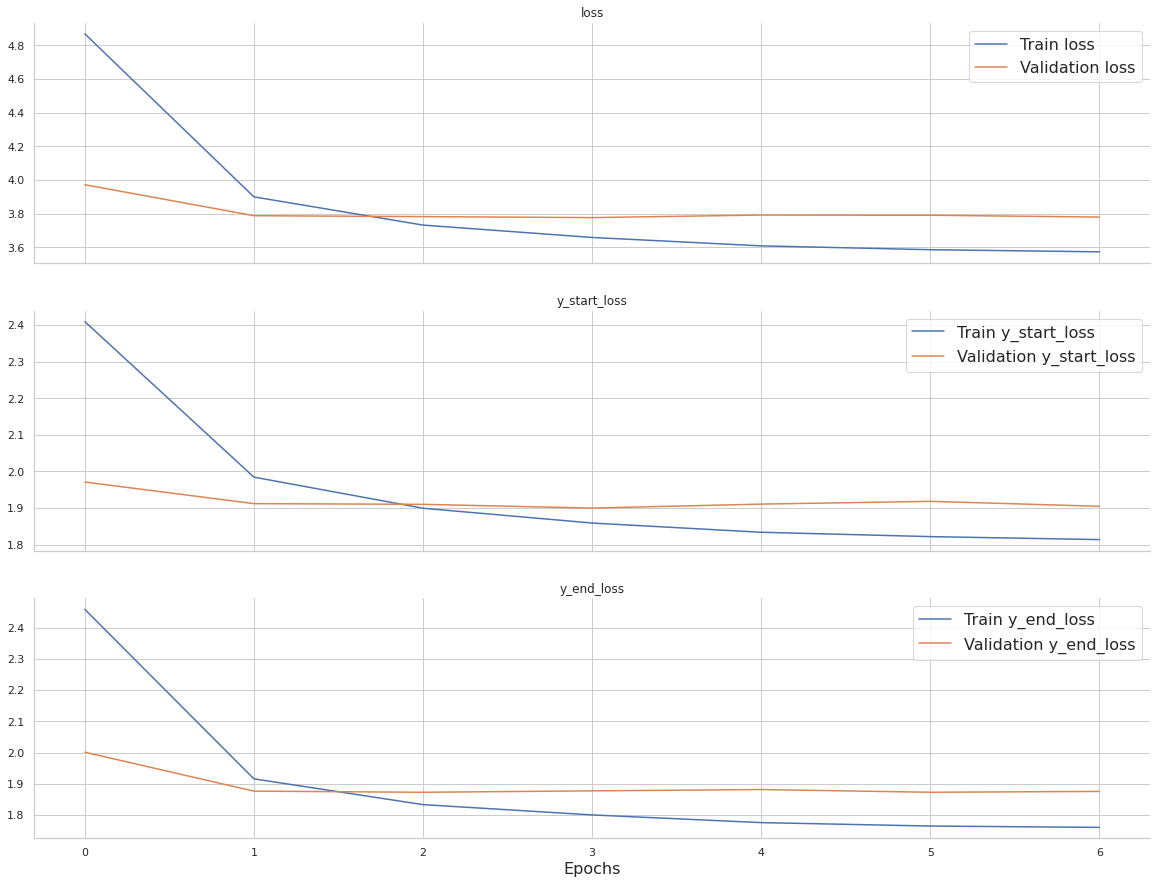

Fold: 4


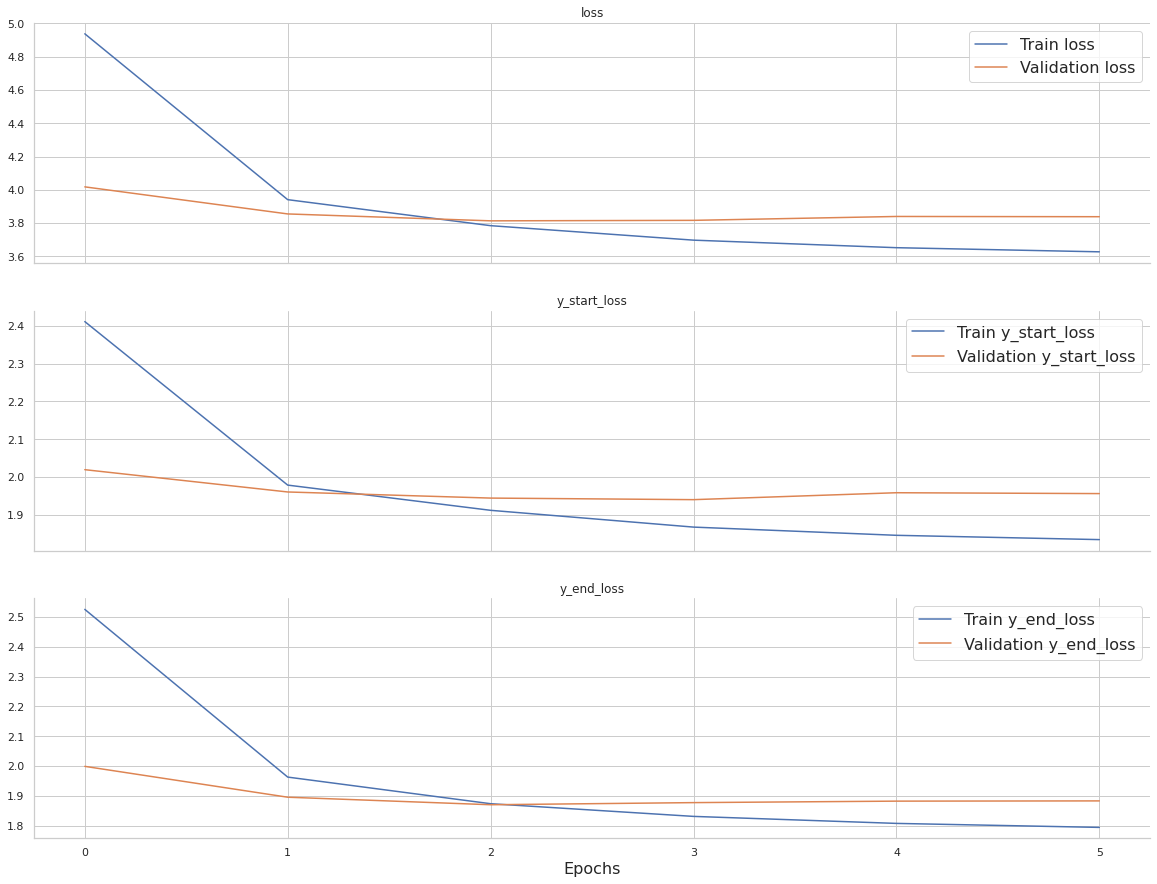

Fold: 5


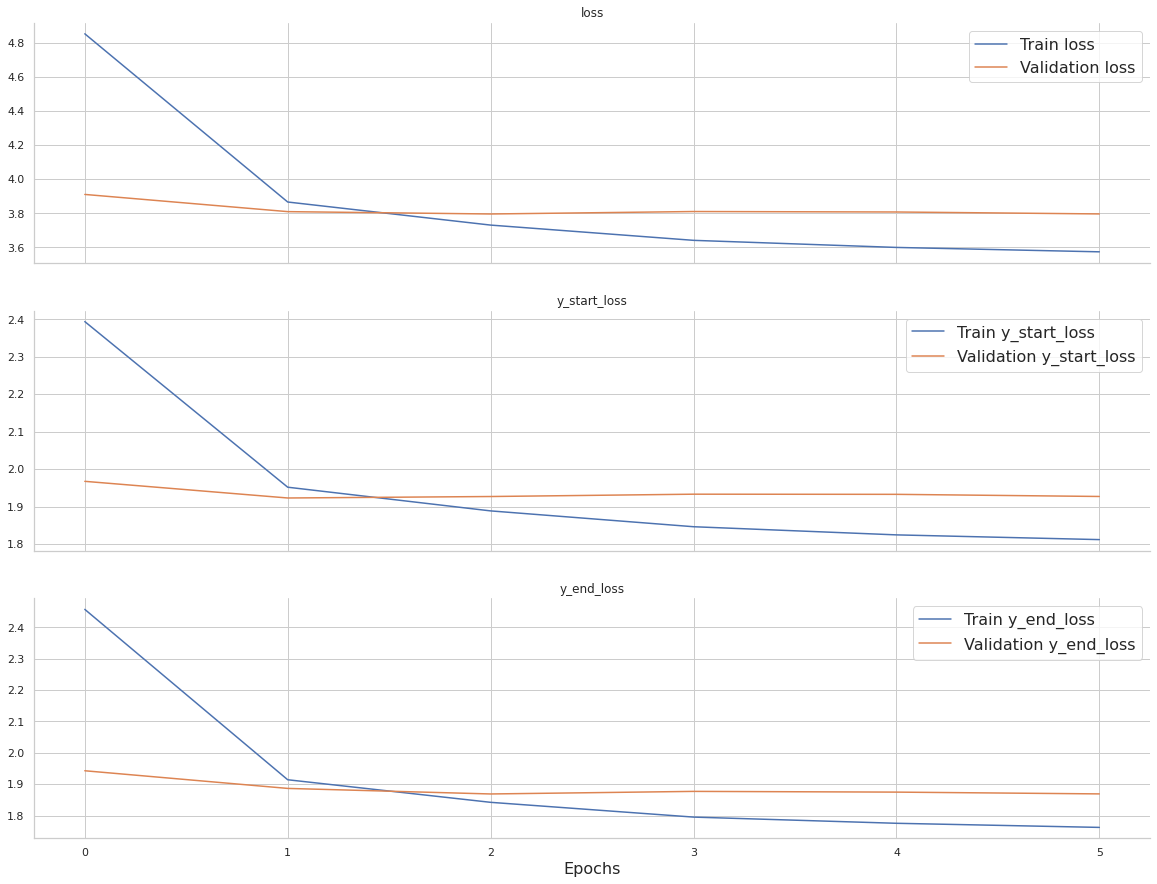

In [14]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation (best model)

In [15]:
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.757281,0.704768,0.052513,0.771537,0.704497,0.766414,0.701419,0.759425,0.711252,0.743186,0.699626,0.745843,0.707045
Sentiment negative,0.619284,0.522282,0.097003,0.648181,0.511260,0.631311,0.520539,0.625641,0.532089,0.591666,0.518820,0.599623,0.528699
Sentiment neutral,0.974730,0.972402,0.002328,0.975219,0.972479,0.974964,0.972164,0.974134,0.973542,0.975194,0.970672,0.974140,0.973155
Sentiment positive,0.600717,0.523532,0.077185,0.619563,0.532402,0.618787,0.514539,0.602575,0.534028,0.580000,0.512555,0.582658,0.524135
0 <= text tokens < 3,0.872821,0.872085,0.000736,0.885417,0.817308,0.864629,0.904762,0.871849,0.888889,0.877232,0.867647,0.864979,0.881818
3 <= text tokens < 20,0.785570,0.741223,0.044347,0.797862,0.739670,0.792393,0.742760,0.787756,0.749733,0.774678,0.729550,0.775160,0.744401
20 <= text tokens < 40,0.717747,0.653377,0.064370,0.734363,0.655875,0.729688,0.646004,0.719801,0.659924,0.699339,0.653760,0.705543,0.651321
40 <= text tokens < 64,0.690857,0.617766,0.073090,0.719694,0.601546,0.717039,0.549581,0.685950,0.587350,0.674592,0.646814,0.657008,0.703540
64 <= text tokens < 120,0.675214,0.621795,0.053419,0.666667,0.576923,0.688034,nan,0.666667,nan,0.688034,nan,0.666667,0.666667


# Model evaluation (last model)

In [16]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.774340,0.705429,0.068911,0.777241,0.703952,0.781791,0.699632,0.774358,0.711470,0.767801,0.697627,0.770509,0.714464
Sentiment negative,0.649542,0.523679,0.125864,0.656578,0.511745,0.661025,0.521085,0.650042,0.534831,0.635911,0.515621,0.644157,0.535111
Sentiment neutral,0.975378,0.972275,0.003102,0.975295,0.972573,0.975386,0.972130,0.975300,0.973961,0.975745,0.970245,0.975162,0.972468
Sentiment positive,0.627068,0.524546,0.102522,0.630117,0.530095,0.640536,0.508365,0.626754,0.531698,0.617992,0.509610,0.619941,0.542963
0 <= text tokens < 3,0.876219,0.869144,0.007075,0.887500,0.817308,0.868996,0.904762,0.873950,0.888889,0.877232,0.852941,0.873418,0.881818
3 <= text tokens < 20,0.800234,0.742161,0.058073,0.803620,0.739990,0.805660,0.738813,0.799242,0.749615,0.795561,0.731716,0.797090,0.750672
20 <= text tokens < 40,0.738050,0.653827,0.084223,0.740147,0.654396,0.747540,0.646787,0.739408,0.660699,0.729377,0.646394,0.733779,0.660857
40 <= text tokens < 64,0.719814,0.614310,0.105504,0.723832,0.590793,0.754243,0.555235,0.713725,0.584413,0.707476,0.640031,0.699795,0.701078
64 <= text tokens < 120,0.669136,0.621795,0.047341,0.666667,0.576923,0.679012,nan,0.666667,nan,0.666667,nan,0.666667,0.666667


# Visualize predictions

In [17]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,imputed,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,False,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,False,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000,sad,0.500000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,0.166667,6,2,False,bullying,0.500000,bullying,0.500000,bullying,0.500000,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,False,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,17,4,False,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,27,27,False,http://www.dothebouncy.com/smf - some shameles...,1.000000,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,17,1,False,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,3,3,False,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,3,3,False,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,19,7,False,wow... u just became cooler.,1.000000,wow...,0.200000,wow...,0.200000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000
